In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [6]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [7]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

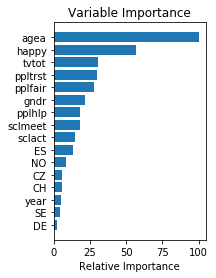

In [8]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [9]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [95]:
#Did not help
#df['age_bucket'] = df['agea'].apply(lambda x: 1 if x <= 20 else 2 if x <= 30 else 3 if x <= 40 else 4 if x <= 50 else 5 if x <=60 else 6 if x <= 70 else 7)

In [98]:
#Did not help
#df['young_or_old'] = df['agea'].apply(lambda x: 1 if x <= 20 else 1 if x >= 70 else 0)

In [10]:
df.groupby('partner').mean()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea
partner,,,,,,,,,,,
1.0,47687.771195,6.492918,3.864353,5.635149,6.062238,5.359266,7.905845,5.030521,2.747856,1.482944,50.979254
2.0,28291.068283,6.512125,3.745373,5.478622,5.913848,5.261008,7.392789,5.512444,2.768985,1.517869,41.316528


In [11]:
# Looks like 'pplfair','ppltrst' and 'pplhlp' are pretty redundant with each
# other. Let's make some averages. Just in case some of the variables are on
# different scales than others (one ranges from 0 to 100, one ranges from 0 to
# 7, for example) we scale them before averaging by subtracting the average of
# each variable from all values in that variable, then dividing by the
# standard deviation.

means = df[['ppltrst','pplfair','pplhlp']].mean(axis=0)
stds = df[['ppltrst','pplfair','pplhlp']].std(axis=0)
df['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)


In [21]:
##Parameter tuning:
#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'ppltrst','pplfair','pplhlp'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

##############################################################


#for depth in range(3):
    #depth = depth + 2
params = {'n_estimators': 5000,
          #'max_depth': depth,
            #'subsample' : 1,
              'learning_rate' : 0.01,
              'max_features' : 'sqrt',
          'loss': 'deviance'}

    # Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
        #'Depth: {}\n'
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.03737043098745226
Percent Type II errors: 0.1627114020731042

Test set accuracy:
Percent Type I errors: 0.06012269938650307
Percent Type II errors: 0.17668711656441718


In [27]:
#Note -- none of the below feature engineering sets improved performance - these are just pasted below for future reference


#try transforming all variables (except the country ones) by sqrt, square, log, etc
#transform the data into a normal distribution - boxcox? - actually only works for continuous output
#try preprocessing standardizing the input variables mean 0 std 1
#last resort: resample to see if distributions of input variables change significantly (can we make them more normal?) -
#also speeds up algorithm
    

#Try transforming all variables (except the country ones) by SQRT, square, log, etc

df2 = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'trust_fair_help'])]
df2.head()
df_sqrt = pd.DataFrame()
for col in df2.columns:
    df_sqrt[col] = np.sqrt(df2[col])
df_sqrt.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea
0,2.44949,1.732051,1.732051,3.162278,2.236068,2.828427,2.236068,2.000000,1.414214,7.745967
1,2.44949,2.449490,2.236068,2.645751,2.236068,3.000000,1.732051,1.414214,1.414214,7.681146
2,2.44949,1.000000,2.828427,2.828427,2.828427,2.645751,2.449490,1.732051,1.000000,4.898979
3,2.44949,2.000000,2.449490,2.449490,2.645751,3.162278,2.449490,1.414214,1.414214,8.000000
4,2.44949,2.236068,2.449490,2.645751,2.236068,2.828427,2.645751,1.414214,1.414214,7.416198


In [28]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df_sqrt.loc[:, ~df_sqrt.columns.isin(['partner', 'cntry', 'idno', 'trust_fair_help'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

##############################################################

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
for depth in range(3):
    depth = depth + 2
    params = {'n_estimators': 5000,
          'max_depth': depth,
            'subsample' : 0.8,
              'learning_rate' : 0.01,
              #'max_features' : 1,
          'loss': 'deviance'}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

# Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Depth: {}\n'
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(depth, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Depth: 2
Training set accuracy:
Percent Type I errors: 0.0463720676486634
Percent Type II errors: 0.1729405346426623

Test set accuracy:
Percent Type I errors: 0.06993865030674846
Percent Type II errors: 0.17914110429447852
Depth: 3
Training set accuracy:
Percent Type I errors: 0.03436988543371522
Percent Type II errors: 0.1498908892525914

Test set accuracy:
Percent Type I errors: 0.08220858895705521
Percent Type II errors: 0.17791411042944785
Depth: 4
Training set accuracy:
Percent Type I errors: 0.017866884888161485
Percent Type II errors: 0.10924713584288052

Test set accuracy:
Percent Type I errors: 0.08711656441717791
Percent Type II errors: 0.18159509202453988


In [29]:
#Try transforming all variables (except the country ones) by sqrt, SQUARE, log, etc

df2 = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'trust_fair_help'])]
df2.head()
df_square = pd.DataFrame()
for col in df2.columns:
    df_square[col] = (df2[col]) * (df2[col])
df_square.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea
0,36,9.0,9.0,100.0,25.0,64.0,25.0,16.0,4.0,3600.0
1,36,36.0,25.0,49.0,25.0,81.0,9.0,4.0,4.0,3481.0
2,36,1.0,64.0,64.0,64.0,49.0,36.0,9.0,1.0,576.0
3,36,16.0,36.0,36.0,49.0,100.0,36.0,4.0,4.0,4096.0
4,36,25.0,36.0,49.0,25.0,64.0,49.0,4.0,4.0,3025.0


In [30]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df_square.loc[:, ~df_square.columns.isin(['partner', 'cntry', 'idno', 'trust_fair_help'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

##############################################################

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
for depth in range(3):
    depth = depth + 2
    params = {'n_estimators': 5000,
          'max_depth': depth,
            #'subsample' : 1,
              'learning_rate' : 0.01,
              #'max_features' : 1,
          'loss': 'deviance'}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

# Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Depth: {}\n'
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(depth, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Depth: 2
Training set accuracy:
Percent Type I errors: 0.04732678668848882
Percent Type II errors: 0.1762138570649209

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18650306748466258
Depth: 3
Training set accuracy:
Percent Type I errors: 0.03764320785597381
Percent Type II errors: 0.15384615384615385

Test set accuracy:
Percent Type I errors: 0.0785276073619632
Percent Type II errors: 0.17914110429447852
Depth: 4
Training set accuracy:
Percent Type I errors: 0.01950354609929078
Percent Type II errors: 0.12315875613747954

Test set accuracy:
Percent Type I errors: 0.09815950920245399
Percent Type II errors: 0.17300613496932515


In [31]:
#Try transforming all variables (except the country ones) by sqrt, square, LOG, etc

df2 = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'trust_fair_help'])]
df2.head()
df_log = pd.DataFrame()
for col in df2.columns:
    ##SOME VALUES ARE ZERO, SO ADD 1 TO EVERYTHING TO AVOID DIVIDE BY ZERO ERROR FOR LOG
    df_log[col] = np.log(df2[col] + 1)
df_log.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea
0,1.94591,1.386294,1.386294,2.397895,1.791759,2.197225,1.791759,1.609438,1.098612,4.110874
1,1.94591,1.945910,1.791759,2.079442,1.791759,2.302585,1.386294,1.098612,1.098612,4.094345
2,1.94591,0.693147,2.197225,2.197225,2.197225,2.079442,1.945910,1.386294,0.693147,3.218876
3,1.94591,1.609438,1.945910,1.945910,2.079442,2.397895,1.945910,1.098612,1.098612,4.174387
4,1.94591,1.791759,1.945910,2.079442,1.791759,2.197225,2.079442,1.098612,1.098612,4.025352


In [32]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df_log.loc[:, ~df_log.columns.isin(['partner', 'cntry', 'idno', 'trust_fair_help'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

##############################################################

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
for depth in range(3):
    depth = depth + 2
    params = {'n_estimators': 5000,
          'max_depth': depth,
            #'subsample' : 1,
              'learning_rate' : 0.01,
              #'max_features' : 1,
          'loss': 'deviance'}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

# Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Depth: {}\n'
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(depth, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Depth: 2
Training set accuracy:
Percent Type I errors: 0.04732678668848882
Percent Type II errors: 0.1762138570649209

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18650306748466258
Depth: 3
Training set accuracy:
Percent Type I errors: 0.03764320785597381
Percent Type II errors: 0.15384615384615385

Test set accuracy:
Percent Type I errors: 0.0785276073619632
Percent Type II errors: 0.17914110429447852
Depth: 4
Training set accuracy:
Percent Type I errors: 0.01950354609929078
Percent Type II errors: 0.12315875613747954

Test set accuracy:
Percent Type I errors: 0.09693251533742331
Percent Type II errors: 0.17300613496932515


In [33]:
#Try transforming all variables (except the country ones) by sqrt, square, log, INVERSE

df2 = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'trust_fair_help'])]
df2.head()
df_inv = pd.DataFrame()
for col in df2.columns:
    ##SOME VALUES ARE ZERO, SO ADD 1 TO EVERYTHING TO AVOID DIVIDE BY ZERO ERROR 
    df_inv[col] = 1/(df2[col] + 1)
df_inv.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea
0,0.142857,0.250000,0.250000,0.090909,0.166667,0.111111,0.166667,0.200000,0.333333,0.016393
1,0.142857,0.142857,0.166667,0.125000,0.166667,0.100000,0.250000,0.333333,0.333333,0.016667
2,0.142857,0.500000,0.111111,0.111111,0.111111,0.125000,0.142857,0.250000,0.500000,0.040000
3,0.142857,0.200000,0.142857,0.142857,0.125000,0.090909,0.142857,0.333333,0.333333,0.015385
4,0.142857,0.166667,0.142857,0.125000,0.166667,0.111111,0.125000,0.333333,0.333333,0.017857


In [34]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df_inv.loc[:, ~df_inv.columns.isin(['partner', 'cntry', 'idno', 'trust_fair_help'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

##############################################################

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
for depth in range(3):
    depth = depth + 2
    params = {'n_estimators': 5000,
          'max_depth': depth,
            #'subsample' : 1,
              'learning_rate' : 0.01,
              #'max_features' : 1,
          'loss': 'deviance'}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

# Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Depth: {}\n'
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(depth, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Depth: 2
Training set accuracy:
Percent Type I errors: 0.04732678668848882
Percent Type II errors: 0.1762138570649209

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18650306748466258
Depth: 3
Training set accuracy:
Percent Type I errors: 0.03764320785597381
Percent Type II errors: 0.15384615384615385

Test set accuracy:
Percent Type I errors: 0.0785276073619632
Percent Type II errors: 0.17914110429447852
Depth: 4
Training set accuracy:
Percent Type I errors: 0.01950354609929078
Percent Type II errors: 0.12315875613747954

Test set accuracy:
Percent Type I errors: 0.09815950920245399
Percent Type II errors: 0.17300613496932515
